In [119]:
import pandas as pd
import numpy as np
import tqdm
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from tensorflow.keras import regularizers
import glob
import matplotlib.pyplot as plt

# Data load

In [2]:
data = pd.read_csv('train.csv')

In [135]:
data.tail()

,image_id,healthy,multiple_diseases,rust,scab
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0
1820,Train_1820,0,0,0,1


In [4]:
#samples = 1000

In [5]:
#data = data[:samples]

In [6]:
train_dir = '/Users/pawelpawlus/Documents/asseco/plant_pathology_classification/images/'


In [7]:
labels = data[['healthy','multiple_diseases','rust','scab']]

In [8]:
labels

,healthy,multiple_diseases,rust,scab
0,0,0,0,1
1,0,1,0,0
2,1,0,0,0
3,0,0,1,0
4,1,0,0,0
...,...,...,...,...
1816,0,0,0,1
1817,1,0,0,0
1818,1,0,0,0
1819,0,0,1,0


In [9]:
labels_array = np.array(labels)

In [10]:
labels_array.shape

(1821, 4)

In [11]:
data.describe()

,healthy,multiple_diseases,rust,scab
count,1821.000000,1821.000000,1821.000000,1821.000000
mean,0.283361,0.049973,0.341571,0.325096
std,0.450754,0.217948,0.474367,0.468539
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [12]:
range(data.shape[0])

range(0, 1821)

In [13]:
image_size = 256
x = []
for i in tqdm.tqdm(range(data.shape[0])):
    img = image.load_img(train_dir+data['image_id'][i]+'.jpg',color_mode='rgb',target_size=(image_size,image_size))
    img= image.img_to_array(img)
    img= img/255
    x.append(img)

100%|██████████| 1821/1821 [00:36<00:00, 49.47it/s]


In [14]:
x_array =np.array(x)

In [15]:
x_array.shape

(1821, 256, 256, 3)

# Data split for training

In [16]:
x_train,x_val,y_train,y_val = train_test_split(x_array,labels_array, test_size=0.2, random_state=42)

In [18]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((1456, 256, 256, 3), (365, 256, 256, 3), (1456, 4), (365, 4))

In [19]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

x_train, y_train = ros.fit_resample(x_train.reshape((-1, image_size * image_size * 3)), y_train)
x_train = x_train.reshape((-1, image_size, image_size, 3))
x_train.shape, y_train.sum(axis=0)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


((2008, 256, 256, 3), array([502, 502, 502, 502]))

In [146]:
oversampled = pd.DataFrame(y_train)

In [155]:
oversampled.describe()

,0,1,2,3
count,2008.000000,2008.000000,2008.000000,2008.000000
mean,0.250000,0.250000,0.250000,0.250000
std,0.433121,0.433121,0.433121,0.433121
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.250000,0.250000,0.250000,0.250000
max,1.000000,1.000000,1.000000,1.000000


In [151]:
data.describe()

,healthy,multiple_diseases,rust,scab
count,1821.000000,1821.000000,1821.000000,1821.000000
mean,0.283361,0.049973,0.341571,0.325096
std,0.450754,0.217948,0.474367,0.468539
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [ ]:
#Używam metody RandomOverSampler w celu ujednolicenia danych. Porównując dane przed i po, teraz są bardziej zbalansowane (wartość mean)

# Image Processing

In [84]:
batch_size = 16
train_data_gen = image.ImageDataGenerator(
    featurewise_center=True,
    rotation_range=5,
    zoom_range = (0.6,0.7),
    brightness_range=(0.5,1.5))

In [85]:
#train_data_gen.fit(x_train)

In [86]:
train_generator = train_data_gen.flow(x_train,
                                      y_train,
                                     batch_size=batch_size)

In [104]:
preview_dir ='/Users/pawelpawlus/Documents/asseco/plant_pathology_classification/preview/'

In [110]:
l=0
for batch in train_data_gen.flow(x_train,
    y_train,
    batch_size=1,
    save_to_dir='/Users/pawelpawlus/Documents/asseco/plant_pathology_classification/preview/',
    save_format='jpeg',
    save_prefix='train'):
    l+=1
    if l < 3:
        continue
    else:
        break


/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [120]:
previews=[]
for filename in glob.glob('/Users/pawelpawlus/Documents/asseco/plant_pathology_classification/preview/*.jpeg'): 
    previews.append(filename)
previews

['/Users/pawelpawlus/Documents/asseco/plant_pathology_classification/preview/train_1997_7708.jpeg',
 '/Users/pawelpawlus/Documents/asseco/plant_pathology_classification/preview/train_394_5818.jpeg',
 '/Users/pawelpawlus/Documents/asseco/plant_pathology_classification/preview/train_310_5854.jpeg']

In [121]:
img_prev =[]
for i in tqdm.tqdm(range(len(previews))):
    img = image.load_img(previews[i])
    img= image.img_to_array(img)
    img= img/255
    img_prev.append(img)
                   

100%|██████████| 3/3 [00:00<00:00, 243.07it/s]


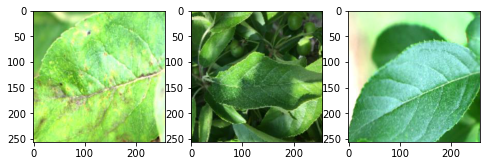

In [126]:
fig=plt.figure(figsize=(8, 8))
for i in range(len(img_prev)):
    img = img_prev[i]
    fig.add_subplot(1, 3, i+1)
    plt.imshow(img)
plt.show()

In [ ]:
#Używam ImageDataGenerator w celu zróżnicowania uczącego zestawu danych poprzez tworzenie zmodyfikowanych wersji obrazów w zestawie danych.

# Model preparation

In [127]:
rlr = ReduceLROnPlateau(patience=10, verbose=1)
es = EarlyStopping(patience=35, restore_best_weights=True, verbose=1)
mc = ModelCheckpoint('model.h5', save_best_only=True, verbose=0)
#rlr - cykliczne zmniejszenie learning rate 
#es - zatrzyamnie modelu kiedy parametry się nie poprawiają
#mc zapisanie modelu z najlepszymi dobranymi parametrami

In [128]:
reg = 0.0005
model = Sequential()
model.add(Conv2D(filters=64,strides=2, kernel_size=(3,3),input_shape=(image_size,image_size,3),padding='same', activation='relu', kernel_regularizer=regularizers.l2(reg)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128,strides = 2,kernel_size=(3,3),activation='relu',padding = 'same',kernel_regularizer=regularizers.l2(reg)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32,kernel_size=(5,5),activation='relu',padding='same',kernel_regularizer=regularizers.l2(reg)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(16,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(4,activation='softmax'))


In [129]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 32)       

In [130]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [28]:
#history = model.fit(x_train,y_train,batch_size=batch_size,epochs=50,validation_data=(x_test,y_test),callbacks=[rlr,es,mc])

In [131]:
history = model.fit_generator(train_generator,
                    epochs=300,
                    steps_per_epoch=train_generator.n//batch_size,
                    validation_data=train_data_gen.flow(x_val,y_val,batch_size=16),
                    callbacks=[rlr,es,mc])
                    

/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/300
125/125 [==============================] - 131s 1s/step - loss: 1.6388 - accuracy: 0.2505 - val_loss: 1.4261 - val_accuracy: 0.2740
Epoch 2/300
125/125 [==============================] - 140s 1s/step - loss: 1.4727 - accuracy: 0.2505 - val_loss: 1.3675 - val_accuracy: 0.1233
Epoch 3/300
125/125 [==============================] - 143s 1s/step - loss: 1.4359 - accuracy: 0.2716 - val_loss: 1.3647 - val_accuracy: 0.2685
Epoch 4/300
125/125 [==============================] - 144s 1s/step - loss: 1.3990 - accuracy: 0.3027 - val_loss: 1.5031 - val_accuracy: 0.2685
Epoch 5/300
125/125 [==============================] - 142s 1s/step - loss: 1.3815 - accuracy: 0.3399 - val_loss: 1.4186 - val_accuracy: 0.3205
Epoch 6/300
125/125 [==============================] - 139s 1s/step - loss: 1.3679 - accuracy: 0.3348 - val_loss: 1.0636 - val_accuracy: 0.3342
Epoch 7/300
125/125 [==============================] - 138s 1s/step - loss: 1.3312 - accuracy: 0.3820 - val_loss: 1.2144 - val_accuracy:

# Post model metrics

In [132]:
history_data = history.history

<function matplotlib.pyplot.show(close=None, block=None)>

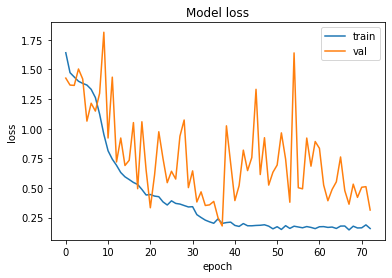

In [133]:
plt.plot(history_data['loss'])
plt.plot(history_data['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'],loc='best')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

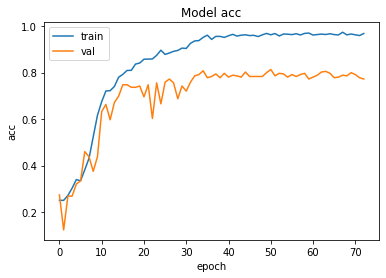

In [134]:
plt.plot(history_data['accuracy'])
plt.plot(history_data['val_accuracy'])
plt.title('Model acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train','val'],loc='best')
plt.show

In [ ]:
#Wytrenowany model wykazuje dokładność na poziomie ~78% na zbiorze walidacyjnym. Jednak niepokojąca jest niestabilna i wysoka wartość val_loss. 
# Może to byś spowodowane zbyt dużym zbiorem danych na jednostkę uczenia albo złym doborem warstw. Trzeba skupić się jeszcze nad formatowaniem danych do uczenia. 
#Można dodać więcej atrybutów dla generatora obrazu oraz dopracować warstwy konwulucyjne. W celu analizy skuteczności wybrałem parametry accuracy i loss. 
#Biorąć pod uwagę dokładność model wydaje się uczyć na dobrym poziomie bez większych problemów. Jednak patrząc na wartości strat widać, że model jest niestabilny i wymaga dopracowania. 

# Test data preparation 

In [136]:
test_data=pd.read_csv('test.csv')

In [139]:
test_x = []
for i in tqdm.tqdm(range(data.shape[0])):
    img = image.load_img(train_dir+test_data['image_id'][i]+'.jpg',color_mode='rgb',target_size=(image_size,image_size))
    img= image.img_to_array(img)
    img= img/255
    test_x.append(img)
    
test_x = np.array(test_x)

100%|██████████| 1821/1821 [00:37<00:00, 48.13it/s]


In [141]:
pred = model.predict(test_x)

In [144]:
sub = pd.read_csv('sample_submission.csv')
submission = pd.DataFrame(pred)
submission.columns = ['healthy', 'multiple_diseases', 'rust', 'scab']
submission['image_id'] = sub['image_id']
submission = submission[['image_id','healthy', 'multiple_diseases', 'rust', 'scab']]
submission.to_csv('submission.csv',index=False)
submission


,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.467407,0.106360,0.076291,0.349942
1,Test_1,0.464268,0.110421,0.076289,0.349022
2,Test_2,0.464919,0.107589,0.076365,0.351127
3,Test_3,0.472837,0.107087,0.073585,0.346491
4,Test_4,0.459871,0.115147,0.081296,0.343686
...,...,...,...,...,...
1816,Test_1816,0.461035,0.111613,0.078345,0.349007
1817,Test_1817,0.470466,0.111550,0.077059,0.340924
1818,Test_1818,0.468591,0.109441,0.075229,0.346739
1819,Test_1819,0.468804,0.106619,0.073787,0.350789
